In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pickle
import os
import warnings
import matplotlib.pyplot as plt
# Dependency imports
from absl import flags
import matplotlib
%matplotlib inline
matplotlib.use("Agg")
from matplotlib import figure  # pylint: disable=g-import-not-at-top
from matplotlib.backends import backend_agg
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.contrib.learn.python.learn.datasets import mnist

# TODO(b/78137893): Integration tests currently fail with seaborn imports.
warnings.simplefilter(action="ignore")

try:
  import seaborn as sns  # pylint: disable=g-import-not-at-top
  HAS_SEABORN = True
except ImportError:
  HAS_SEABORN = False

tfd = tfp.distributions

IMAGE_SHAPE = [28, 28, 1]

flags.DEFINE_float("learning_rate",
                   default=0.001,
                   help="Initial learning rate.")
flags.DEFINE_integer("max_steps",
                     default=300,
                     help="Number of training steps to run.")
flags.DEFINE_integer("batch_size",
                     default=128,
                     help="Batch size.")
flags.DEFINE_string("data_dir",
                    default=os.path.join(os.getenv("TEST_TMPDIR", "/tmp"),
                                         "bayesian_neural_network/data"),
                    help="Directory where data is stored (if using real data).")
flags.DEFINE_string(
    "model_dir",
    default=os.path.join(os.getenv("TEST_TMPDIR", "/tmp"),
                         "bayesian_neural_network/"),
    help="Directory to put the model's fit.")
flags.DEFINE_integer("viz_steps",
                     default=100,
                     help="Frequency at which save visualizations.")
flags.DEFINE_integer("num_monte_carlo",
                     default=50,
                     help="Network draws to compute predictive probabilities.")
flags.DEFINE_bool("fake_data",
                  default=None,
                  help="If true, uses fake data. Defaults to real data.")

flags.DEFINE_integer(
    "mixture_components",
    default=10,
    help="Number of mixture components to use in the prior. Each component is "
         "a diagonal normal distribution. The parameters of the components are "
         "intialized randomly, and then learned along with the rest of the "
         "parameters. If `analytic_kl` is True, `mixture_components` must be "
         "set to `1`.")
flags.DEFINE_bool(
    "analytic_kl",
    default=False,
    help="Whether or not to use the analytic version of the KL. When set to "
         "False the E_{Z~q(Z|X)}[log p(Z)p(X|Z) - log q(Z|X)] form of the ELBO "
         "will be used. Otherwise the -KL(q(Z|X) || p(Z)) + "
         "E_{Z~q(Z|X)}[log p(X|Z)] form will be used. If analytic_kl is True, "
         "then you must also specify `mixture_components=1`.")

FLAGS = flags.FLAGS
import sys
FLAGS(sys.argv, known_only=True)

/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['/Users/karimimohammedbelhal/Desktop/ongoing/hostnfly/deeptech/lib/python2.7/site-packages/ipykernel_launcher.py',
 '-f',
 '/Users/karimimohammedbelhal/Library/Jupyter/runtime/kernel-407032a4-c16e-432d-88d4-de98f7722c7c.json']

In [2]:
tf.set_random_seed(1)

In [3]:
def display_draws(loss, train_x, EPOCH_NUM):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
    plt.plot(np.arange(EPOCH_NUM), loss / len(train_x), label='Train')
    plt.legend(fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Negated ELBO', fontsize=15)
    plt.show()

In [4]:
tf.gfile.MakeDirs(FLAGS.model_dir)
mnist_data = mnist.read_data_sets(FLAGS.data_dir, reshape=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/bayesian_neural_network/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/bayesian_neural_network/data/train-labels-idx1-ubyte.gz
Extracting /tmp/bayesian_neural_network/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/bayesian_neural_network/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
def build_input_pipeline(mnist_data, batch_size, heldout_size):
  """Build an Iterator switching between train and heldout data."""

  # Build an iterator over training batches.
  training_dataset = tf.data.Dataset.from_tensor_slices(
      (mnist_data.train.images, np.int32(mnist_data.train.labels)))
  training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
  training_iterator = training_batches.make_one_shot_iterator()

  # Build a iterator over the heldout set with batch_size=heldout_size,
  # i.e., return the entire heldout set as a constant.
  heldout_dataset = tf.data.Dataset.from_tensor_slices(
      (mnist_data.validation.images,
       np.int32(mnist_data.validation.labels)))
  heldout_frozen = (heldout_dataset.take(heldout_size).
                    repeat().batch(heldout_size))
  heldout_iterator = heldout_frozen.make_one_shot_iterator()

  # Combine these into a feedable iterator that can switch between training
  # and validation inputs.
  handle = tf.placeholder(tf.string, shape=[])
  feedable_iterator = tf.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
  images, labels = feedable_iterator.get_next()

  return images, labels, handle, training_iterator, heldout_iterator

In [6]:
(images, labels, handle,
   training_iterator, heldout_iterator) = build_input_pipeline(
       mnist_data, FLAGS.batch_size, mnist_data.validation.num_examples)

In [7]:
with tf.name_scope("bayesian_neural_net", values=[images]):
    neural_net = tf.keras.Sequential([
        tfp.layers.Convolution2DFlipout(6,
                                        kernel_size=5,
                                        padding="SAME",
                                        activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=[2, 2],
                                     strides=[2, 2],
                                     padding="SAME"),
        tfp.layers.Convolution2DFlipout(16,
                                        kernel_size=5,
                                        padding="SAME",
                                        activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=[2, 2],
                                     strides=[2, 2],
                                     padding="SAME"),
        tfp.layers.Convolution2DFlipout(120,
                                        kernel_size=5,
                                        padding="SAME",
                                        activation=tf.nn.relu),
        tf.keras.layers.Flatten(),
        tfp.layers.DenseFlipout(84, activation=tf.nn.relu),
        tfp.layers.DenseFlipout(10)
        ])

    logits = neural_net(images)
    labels_distribution = tfd.Categorical(logits=logits)

In [8]:
neg_log_likelihood = -tf.reduce_mean(labels_distribution.log_prob(labels))
kl = sum(neural_net.losses) / mnist_data.train.num_examples
elbo_loss = neg_log_likelihood + kl

In [9]:
#Some params
total = mnist_data.train.num_examples
epoch_num = 2
N =  FLAGS.batch_size

In [10]:
predictions = tf.argmax(logits, axis=1)
accuracy, accuracy_update_op = tf.metrics.accuracy(labels=labels, predictions=predictions)

# ADAM

In [8]:
names = []
qmeans = []
qstds = []
for i, layer in enumerate(neural_net.layers):
    try:
        q = layer.kernel_posterior
    except AttributeError:
        continue
    names.append("Layer {}".format(i))
    qmeans.append(q.mean())
    qstds.append(q.stddev())

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)
    train_op = optimizer.minimize(elbo_loss)
init_op = tf.group(tf.global_variables_initializer(),
                     tf.local_variables_initializer())

In [10]:
train_lossadam = np.zeros(FLAGS.max_steps)
train_accadam = np.zeros(FLAGS.max_steps)

In [11]:
sess = tf.InteractiveSession()

In [12]:
sess.run(init_op)

# Run the training loop.
train_handle = sess.run(training_iterator.string_handle())
heldout_handle = sess.run(heldout_iterator.string_handle())

In [13]:
#for step in range(FLAGS.max_steps):
for step in range(10):
    _ = sess.run([train_op, accuracy_update_op],feed_dict={handle: train_handle})
    train_lossadam[step],train_accadam[step] = sess.run([elbo_loss, accuracy],feed_dict={handle: train_handle})

In [16]:
adam = train_lossadam[0:100]
#save loss
with open('newlosses/adamloss', 'wb') as fp:
    pickle.dump(adam, fp)

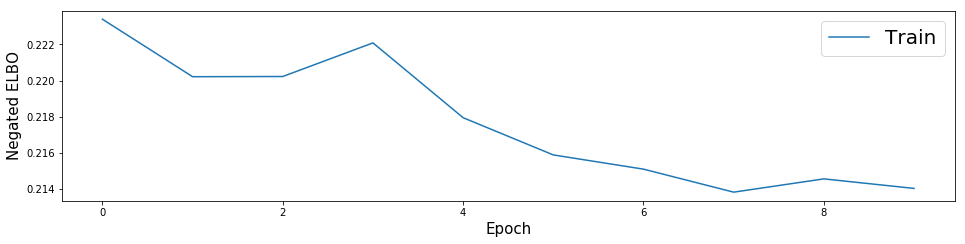

In [32]:
X_batch, Y_batch = mnist_data.train.next_batch(FLAGS.batch_size)
display_draws(train_lossadam[0:10,], X_batch, 10)

# BayesByBackprop

In [63]:
names = []
qmeans = []
qstds = []
for i, layer in enumerate(neural_net.layers):
    try:
        q = layer.kernel_posterior
    except AttributeError:
        continue
    names.append("Layer {}".format(i))
    qmeans.append(q.mean())
    qstds.append(q.stddev())

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=FLAGS.learning_rate)
    train_op = optimizer.minimize(elbo_loss)
init_op = tf.group(tf.global_variables_initializer(),
                     tf.local_variables_initializer())

In [64]:
train_lossbbb = np.zeros(FLAGS.max_steps)
train_accbbb = np.zeros(FLAGS.max_steps)

In [65]:
sess = tf.InteractiveSession()

In [66]:
sess.run(init_op)

# Run the training loop.
train_handle = sess.run(training_iterator.string_handle())
heldout_handle = sess.run(heldout_iterator.string_handle())

In [67]:
#for step in range(FLAGS.max_steps):
for step in range(10):
    _ = sess.run([train_op, accuracy_update_op],feed_dict={handle: train_handle})
    train_lossbbb[step],train_accbbb[step] = sess.run([elbo_loss, accuracy],feed_dict={handle: train_handle})

In [69]:
bbb = train_lossbbb[0:100]
#save loss
with open('newlosses/bbbloss', 'wb') as fp:
    pickle.dump(bbb, fp)

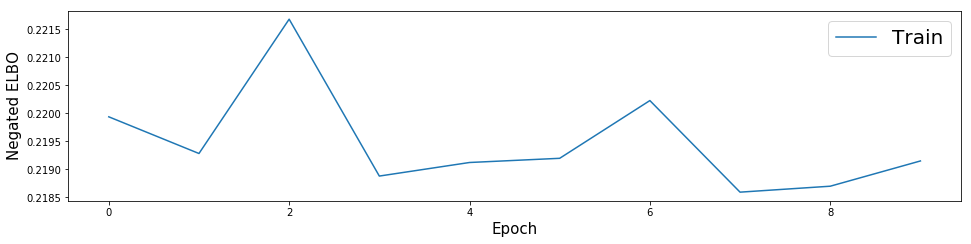

In [70]:
X_batch, Y_batch = mnist_data.train.next_batch(FLAGS.batch_size)
display_draws(train_lossbbb[0:10,], X_batch, 10)

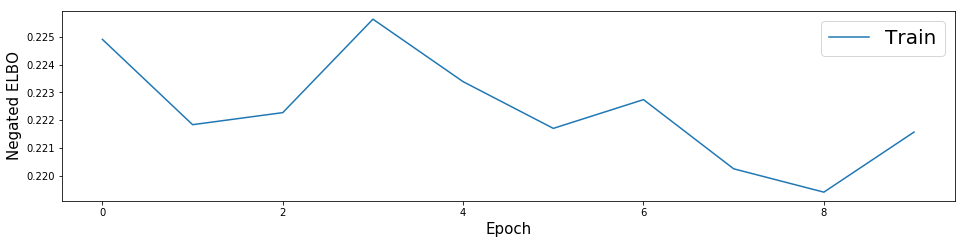

In [39]:
X_batch, Y_batch = mnist_data.train.next_batch(FLAGS.batch_size)
display_draws(train_lossbbb[0:10,], X_batch, 10)

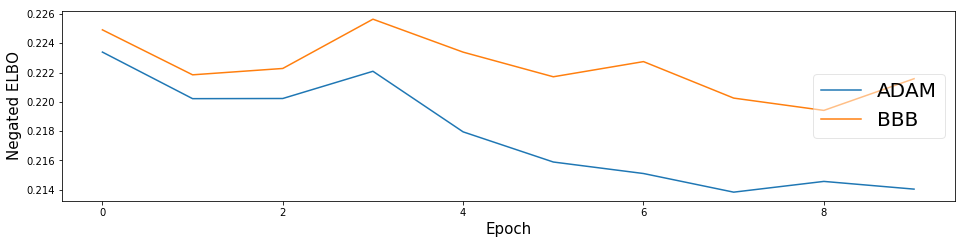

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(10), train_lossadam[0:10,] / len(X_batch), label='ADAM')
plt.plot(np.arange(10), train_lossbbb[0:10,] / len(X_batch), label='BBB')
leg = plt.legend(fontsize=20,fancybox=True, loc='right')
leg.get_frame().set_alpha(0.5)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Negated ELBO', fontsize=15)
plt.show()

# MISSO

In [71]:
names = []
qmeans = []
qstds = []
for i, layer in enumerate(neural_net.layers):
    try:
        q = layer.kernel_posterior
    except AttributeError:
        continue
    names.append("Layer {}".format(i))
    qmeans.append(q.mean())
    qstds.append(q.stddev())

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=FLAGS.learning_rate)
    train_op = optimizer.minimize(elbo_loss)
init_op = tf.group(tf.global_variables_initializer(),
                     tf.local_variables_initializer())

In [72]:
train_lossmisso = np.zeros(FLAGS.max_steps)
train_accmisso = np.zeros(FLAGS.max_steps)

In [73]:
sess = tf.InteractiveSession()
sess.run(init_op)

# Run the training loop.
train_handle = sess.run(training_iterator.string_handle())
heldout_handle = sess.run(heldout_iterator.string_handle())

In [74]:
newloss,newacc = sess.run([elbo_loss, accuracy],feed_dict={handle: train_handle})

In [97]:
#First pass over the data with SGD (keeping in memory all the gradients)
gradients = []
#for _ in range(0,total, N):
for _ in range(10):
    print(_)
    grads = tf.gradients(elbo_loss, tf.trainable_variables())
    var_updates = []
    var_list = tf.trainable_variables()
    for grad, var in zip(grads, var_list):
        var_updates.append(var.assign_sub(FLAGS.learning_rate * grad))
    train_op = tf.group(*var_updates)
    gradients.append(grads)
    sess.run(train_op,feed_dict={handle: train_handle})
        
train_lossmisso[0],train_accbbb[0] = sess.run([elbo_loss, accuracy],feed_dict={handle: train_handle})

0
1
2
3
4
5
6
7
8
9


In [ ]:
for epoch in range(1,epoch_num):
    for i in range(0,total/N):
        print(epoch)
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        grads = tf.gradients(elbo_loss, tf.trainable_variables())
        gradients[i] = grads
        var_updates = []
        var_list = tf.trainable_variables()
        for gradstemp in gradients:
            for grad, var in zip(gradstemp, var_list):
                var_updates.append(var.assign_sub(learning_rate * grad))
        train_op = tf.group(*var_updates)
        sess.run([train_op, accuracy_update_op],feed_dict={handle: train_handle})
        #info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_lossmisso[step],train_accbbb[step] = sess.run([elbo_loss, accuracy],feed_dict={handle: train_handle})

In [ ]:
misso = train_lossmisso[0:100]
#save loss
with open('newlosses/missoloss', 'wb') as fp:
    pickle.dump(misso, fp)